# Just pandas things

It's possible that Python wouldn't have become [the lingua franca of data science if it wasn't for pandas](https://stackoverflow.blog/2017/09/14/python-growing-quickly/). The package's exponential growth on Stack Overflow means two things:
1. It's getting increasingly popular.
2. It can be frustrating to use sometimes (hence the high number of questions).

This repo contains a few peculiar things I've learned about pandas that have made my life easier and my code faster. This post isn't a friendly tutorial for beginners, but a friendly introduction to pandas weirdness.

To demonstrate the use of pandas, we'll be using the interview reviews scraped from Glassdoor in 2019. The data is stored in the folder `data` under the name `interviews.csv`.

I'll continue updating this repo as I have more time. As I'm still learning pandas quirks, feedback is much appreciated!

![](https://i.pinimg.com/originals/9e/7c/78/9e7c7816c30327890dc94ba16e5dac1b.jpg)

In [12]:
import pandas as pd
df = pd.read_csv("data/interviews.csv")

print(df.shape)
df.head()

(17654, 10)


,Company,Title,Job,Level,Date,Upvotes,Offer,Experience,Difficulty,Review
0,Apple,Software Engineer,Software Engineer,Engineer,"Aug 7, 2019",0,No offer,0.0,Medium,Application I applied through a staffing agen...
1,Apple,Software Engineer,Software Engineer,Engineer,"Aug 8, 2019",0,Accepted offer,1.0,Hard,Application I applied online. The process too...
2,Apple,Software Engineer,Software Engineer,Engineer,NaN,0,Declined offer,0.0,Medium,Application The process took 4 weeks. I inter...
3,Apple,Software Engineer,Software Engineer,Engineer,NaN,9,Declined offer,-1.0,Medium,Application The process took a week. I interv...
4,Apple,Software Engineer,Software Engineer,Engineer,"May 29, 2009",2,No offer,0.0,Medium,Application I applied through an employee ref...


## 1. pandas is column-major
Pandas is built around `DataFrame`, a concept inspired by R's Data Frame, which is, in turn, similar to tables in relational databases. A `DataFrame` is a two-dimensional table with rows and columns.

One important thing to know about pandas is that it's column-major, which explains many of its quirks.

Column-major means consecutive elements in a column are stored next to each other in memory. Row-major means the same but for elements in a row. Because modern computers process sequential data more efficiently than nonsequential data, if a table is row-major, accessing its rows will be much faster than accessing its columns.

In NumPy, major order can be specified. When a `ndarray` is created, it's row-major by default if you don't specify the order.

Like R's Data Frame, pandas' `DataFrame` is column-major. People coming to pandas from NumPy tend to treat `DataFrame` the way they would `ndarray`, e.g. trying to access data by rows, and find `DataFrame` slow.

**Note**: A column in a `DataFrame` is a `Series`. You can think of a `DataFrame` as a bunch of `Series` being stored next to each other in memory.

**For our dataset, accessing a row takes about 50x longer than accessing a column in our `DataFrame`.**

In [2]:
# Get the column `date`, 1000 loops
%timeit -n1000 df["Date"]

# Get the first row, 1000 loops
%timeit -n1000 df.iloc[0]

2.65 µs ± 536 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
98.6 µs ± 5.11 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


### 1.1 Iterating over rows
#### 1.1.1 `.apply()`
pandas documentation has [a warning box](https://pandas.pydata.org/pandas-docs/stable/user_guide/basics.html#iteration) that basically tells you not to iterate over rows because it's slow.

Before iterating over rows, think about what you want to do with each row, pack that into a function and use methods like `.apply()` to apply the function to all rows.

For example, to scale the "Experience" column by the number of "Upvotes" each review has, one way is to iterate over rows and multiple the "Upvotes" value by the "Experience" value of that row. But you can also use `.apply()` with a `lambda` function.

In [3]:
%timeit -n1 df.apply(lambda x: x["Experience"] * x["Upvotes"], axis=1)

252 ms ± 25.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### 1.1.2 `.iterrows()` and `.itertuples()`
If you really want to iterate over rows, one naive way is to use `.iterrows()`. It returns a generator that generates row by row and it's very slow.

In [4]:
%timeit -n1 [row for index, row in df.iterrows()]

543 ms ± 14.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [6]:
# This is what a row looks like as a pandas object
for index, row in df.iterrows():
    print(row)
    break

Company                                                   Apple
Title                                         Software Engineer
Job                                           Software Engineer
Level                                                  Engineer
Date                                                Aug 7, 2019
Upvotes                                                       0
Offer                                                  No offer
Experience                                                  0.0
Difficulty                                               Medium
Review        Application  I applied through a staffing agen...
Name: 0, dtype: object


`.itertuples()` returns rows in the `namedtuple` format. It still lets you access each row and it's about 40x faster than `.iterrows()`.

In [7]:
%timeit -n1 [row for row in df.itertuples()]

24.2 ms ± 1.32 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
# This is what a row looks like as a namedtuple.
for row in df.itertuples():
    print(row)
    break

Pandas(Index=0, Company='Apple', Title='Software Engineer', Job='Software Engineer', Level='Engineer', Date='Aug 7, 2019', Upvotes=0, Offer='No offer', Experience=0.0, Difficulty='Medium', Review='Application  I applied through a staffing agency. I interviewed at Apple (Sunnyvale, CA) in March 2019.  Interview  The interviewer asked me about my background. Asked few questions from the resume. Asked about my proficiency on data structures. Asked me how do you sort hashmap keys based on values.  Interview Questions Write a program that uses two threads to print the numbers from 1 to n.')


#### 1.1.3 Converting DataFrame to row-major order
If you need to do a lot of row operations, you might want to convert your `DataFrame` to a NumPy's row-major `ndarray`, then iterating through the rows.

In [10]:
# Now, iterating through our DataFrame is 100x faster.
%timeit -n1 df_np = df.to_numpy(); rows = [row for row in df_np]

6.49 ms ± 809 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


Accessing a row or a column of our `ndarray` takes nanoseconds instead of microseconds.

In [11]:
df_np = df.to_numpy()
%timeit -n1000 df_np[0]
%timeit -n1000 df_np[:,0]

153 ns ± 5.43 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
269 ns ± 62.9 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


### 1.2. Ordering slicing operations
Because pandas is column-major, if you want to do multiple slicing operations, **always do the column-based slicing operations first**.

For example, if you want to get the review from the first row of the data, there are two slicing operations:
- get row (row-based operation)
- get review (column-based operation)

Get row -> get review is 25x slower than get review -> get row.

**Note**: You can also just use `df.loc[0, "Review"]` to calculate the memory address to retrieve the item. Its performance is comparable to get review then get row.

In [13]:
%timeit -n1000 df["Review"][0]
%timeit -n1000 df.iloc[0]["Review"]
%timeit -n1000 df.loc[0, "Review"]

6.25 µs ± 988 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
110 µs ± 5.36 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
The slowest run took 4.44 times longer than the fastest. This could mean that an intermediate result is being cached.
12.8 µs ± 9.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


## 2. SettingWithCopyWarning
Sometimes, when you try to assign values to a subset of data in a DataFrame, you get `SettingWithCopyWarning`. Don't ignore the warning because it means sometimes, the assignment works (example 1), but sometimes, it doesn't (example 2).

In [14]:
# Example 1: Changing the review of the first row.
df["Review"][0] = "I like Orange better."
# Even though with the warning, the assignment works. The review is updated.
df.head(1)

C:\Users\amirm\AppData\Local\Temp\ipykernel_4316\159866291.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Review"][0] = "I like Orange better."


,Company,Title,Job,Level,Date,Upvotes,Offer,Experience,Difficulty,Review
0,Apple,Software Engineer,Software Engineer,Engineer,"Aug 7, 2019",0,No offer,0.0,Medium,I like Orange better.


In [15]:
# Example 2: Changing the company name Apple to Orange.
df[df["Company"] == "Apple"]["Company"] = "Orange"
# With the warning, the assignment doesn't work. The company name is still Apple.
df.head(1)

C:\Users\amirm\AppData\Local\Temp\ipykernel_4316\2314620877.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[df["Company"] == "Apple"]["Company"] = "Orange"


,Company,Title,Job,Level,Date,Upvotes,Offer,Experience,Difficulty,Review
0,Apple,Software Engineer,Software Engineer,Engineer,"Aug 7, 2019",0,No offer,0.0,Medium,I like Orange better.


### 2.1. `View` vs. `Copy`
To understand this weird behavior, we need to understand two concepts in pandas: `View` vs. `Copy`.
- `View` is the actual `DataFrame` you want to work with.
- `Copy` is a copy of that actual `DataFrame`, which will be thrown away as soon as the operation is done.

So if you try to do an assignment on a `Copy`, the assignment won't work. 

`SettingWithCopyWarning` doesn't mean you're making changes to a `Copy`. It means that the thing you're making changes to might be a `Copy` or a `View`, and pandas can't tell you.

The ambiguity happens because of `__getitem__` operation.
`__getitem__` sometimes returns a `Copy`, sometimes a `View`, and pandas makes no guarantee.

In [16]:
# df["Review"][0] = "I like Orange better."
# can be understood as
# `df.__getitem__("Review").__setitem__(0, "I like Orange better.")`

In [17]:
# df[df["Company"] == "Apple"]["Company"] = "Orange"
# can be understood as
# df.__getitem__(where df["Company"] == "Apple").__setitem__("Company", "Orange")

### 2.2 Solutions
#### 2.2.1 Combine all chained operations into one single operation
To avoid `__getitem__` ambiguity, you can combine all your operations into one single operation.
`.loc[]` is usually great for that.

In [18]:
# Changing the review of the first row.
df.loc[0, "Review"] = "Orange is love. Orange is life."
df.head()

,Company,Title,Job,Level,Date,Upvotes,Offer,Experience,Difficulty,Review
0,Apple,Software Engineer,Software Engineer,Engineer,"Aug 7, 2019",0,No offer,0.0,Medium,Orange is love. Orange is life.
1,Apple,Software Engineer,Software Engineer,Engineer,"Aug 8, 2019",0,Accepted offer,1.0,Hard,Application I applied online. The process too...
2,Apple,Software Engineer,Software Engineer,Engineer,NaN,0,Declined offer,0.0,Medium,Application The process took 4 weeks. I inter...
3,Apple,Software Engineer,Software Engineer,Engineer,NaN,9,Declined offer,-1.0,Medium,Application The process took a week. I interv...
4,Apple,Software Engineer,Software Engineer,Engineer,"May 29, 2009",2,No offer,0.0,Medium,Application I applied through an employee ref...


In [19]:
# Changing the company name Apple to Orange.
df.loc[df["Company"] == "Apple", "Company"] = "Orange"
df.head()

,Company,Title,Job,Level,Date,Upvotes,Offer,Experience,Difficulty,Review
0,Orange,Software Engineer,Software Engineer,Engineer,"Aug 7, 2019",0,No offer,0.0,Medium,Orange is love. Orange is life.
1,Orange,Software Engineer,Software Engineer,Engineer,"Aug 8, 2019",0,Accepted offer,1.0,Hard,Application I applied online. The process too...
2,Orange,Software Engineer,Software Engineer,Engineer,NaN,0,Declined offer,0.0,Medium,Application The process took 4 weeks. I inter...
3,Orange,Software Engineer,Software Engineer,Engineer,NaN,9,Declined offer,-1.0,Medium,Application The process took a week. I interv...
4,Orange,Software Engineer,Software Engineer,Engineer,"May 29, 2009",2,No offer,0.0,Medium,Application I applied through an employee ref...


#### 2.2.2 Raise an error
I believe `SettingWithCopyWarning` should be an Exception instead of a warning. You can change this warning into an exception with pandas' magic `set_option()`.

In [17]:
pd.set_option("mode.chained_assignment", "raise")
# Running this will show you an Exception
# df["Review"][0] = "I like Orange better."

## 3. Indexing and slicing

### 3.1 `.iloc[]`: selecting rows based on integer indices
`.iloc[]` lets you select rows by integer indices.

In [20]:
# Accessing the third row of a `DataFrame`.
df.iloc[3]

Company                                                  Orange
Title                                         Software Engineer
Job                                           Software Engineer
Level                                                  Engineer
Date                                                        NaN
Upvotes                                                       9
Offer                                            Declined offer
Experience                                                 -1.0
Difficulty                                               Medium
Review        Application  The process took a week. I interv...
Name: 3, dtype: object

Slicing with `.iloc[]` is similar to slicing in Python. If you want a refresh on how slicing in Python works, see [Python-is-cool](https://github.com/chiphuyen/python-is-cool).

In [19]:
# Selecting the last 6 rows
df.iloc[-6:]

,Company,Title,Job,Level,Date,Upvotes,Offer,Experience,Difficulty,Review
17648,Tencent,Software Engineer,Software Engineer,Engineer,"Nov 4, 2012",0,No offer,NaN,NaN,Application I applied online. The process too...
17649,Tencent,Software Engineer,Software Engineer,Engineer,"May 25, 2012",0,Declined offer,0.0,Medium,Application I applied online. The process too...
17650,Tencent,Software Engineer,Software Engineer,Engineer,"Mar 15, 2014",0,No offer,NaN,NaN,Application I applied through college or univ...
17651,Tencent,Software Engineer,Software Engineer,Engineer,"Sep 22, 2015",0,Accepted offer,1.0,Medium,Application I applied through college or univ...
17652,Tencent,Software Engineer,Software Engineer,Engineer,"Jul 4, 2017",0,Declined offer,1.0,Medium,Application I applied through college or univ...
17653,Tencent,Software Engineer,Software Engineer,Engineer,"Sep 30, 2016",0,Declined offer,0.0,Easy,Application I applied online. The process too...


In [20]:
# Selecting 1 from every 2 rows in the last 6 rows
df.iloc[-6::2]

,Company,Title,Job,Level,Date,Upvotes,Offer,Experience,Difficulty,Review
17648,Tencent,Software Engineer,Software Engineer,Engineer,"Nov 4, 2012",0,No offer,NaN,NaN,Application I applied online. The process too...
17650,Tencent,Software Engineer,Software Engineer,Engineer,"Mar 15, 2014",0,No offer,NaN,NaN,Application I applied through college or univ...
17652,Tencent,Software Engineer,Software Engineer,Engineer,"Jul 4, 2017",0,Declined offer,1.0,Medium,Application I applied through college or univ...


### 3.2 `.loc[]`: selecting rows by labels or boolean masks
`.loc[]` lets you select rows based on one of the two things:
- boolean masks
- labels

#### 3.2.1 Selecting rows by boolean masks
If you want to select all the rows where candidates declined offer, you can do it with two steps:
1. Create a boolean mask on whether the "Offer" column equals to "Declined offer"
2. Use that mask to select rows

In [21]:
df.loc[df["Offer"] == "Declined offer"]
# This is equivalent to:
# mask = df["Offer"] == "Declined offer"
# df.loc[mask]

,Company,Title,Job,Level,Date,Upvotes,Offer,Experience,Difficulty,Review
2,Orange,Software Engineer,Software Engineer,Engineer,NaN,0,Declined offer,0.0,Medium,Application The process took 4 weeks. I inter...
3,Orange,Software Engineer,Software Engineer,Engineer,NaN,9,Declined offer,-1.0,Medium,Application The process took a week. I interv...
7,Orange,Software Engineer,Software Engineer,Engineer,"Jul 26, 2019",1,Declined offer,-1.0,Medium,Application The process took 4+ weeks. I inte...
17,Orange,Software Engineer,Software Engineer,Engineer,"Feb 27, 2010",7,Declined offer,-1.0,Medium,Application The process took 1 day. I intervi...
65,Orange,Software Engineer,Software Engineer,Engineer,"May 6, 2012",1,Declined offer,1.0,Easy,Application The process took 2 days. I interv...
...,...,...,...,...,...,...,...,...,...,...
17643,Tencent,Software Engineer,Software Engineer,Engineer,"Apr 9, 2016",0,Declined offer,1.0,Medium,Application I applied online. I interviewed a...
17646,Tencent,Software Engineer,Software Engineer,Engineer,"May 28, 2010",0,Declined offer,0.0,Easy,Application I applied through an employee ref...
17649,Tencent,Software Engineer,Software Engineer,Engineer,"May 25, 2012",0,Declined offer,0.0,Medium,Application I applied online. The process too...
17652,Tencent,Software Engineer,Software Engineer,Engineer,"Jul 4, 2017",0,Declined offer,1.0,Medium,Application I applied through college or univ...


In [22]:
df[df["Offer"] == "Declined offer"]

,Company,Title,Job,Level,Date,Upvotes,Offer,Experience,Difficulty,Review
2,Orange,Software Engineer,Software Engineer,Engineer,NaN,0,Declined offer,0.0,Medium,Application The process took 4 weeks. I inter...
3,Orange,Software Engineer,Software Engineer,Engineer,NaN,9,Declined offer,-1.0,Medium,Application The process took a week. I interv...
7,Orange,Software Engineer,Software Engineer,Engineer,"Jul 26, 2019",1,Declined offer,-1.0,Medium,Application The process took 4+ weeks. I inte...
17,Orange,Software Engineer,Software Engineer,Engineer,"Feb 27, 2010",7,Declined offer,-1.0,Medium,Application The process took 1 day. I intervi...
65,Orange,Software Engineer,Software Engineer,Engineer,"May 6, 2012",1,Declined offer,1.0,Easy,Application The process took 2 days. I interv...
...,...,...,...,...,...,...,...,...,...,...
17643,Tencent,Software Engineer,Software Engineer,Engineer,"Apr 9, 2016",0,Declined offer,1.0,Medium,Application I applied online. I interviewed a...
17646,Tencent,Software Engineer,Software Engineer,Engineer,"May 28, 2010",0,Declined offer,0.0,Easy,Application I applied through an employee ref...
17649,Tencent,Software Engineer,Software Engineer,Engineer,"May 25, 2012",0,Declined offer,0.0,Medium,Application I applied online. The process too...
17652,Tencent,Software Engineer,Software Engineer,Engineer,"Jul 4, 2017",0,Declined offer,1.0,Medium,Application I applied through college or univ...


#### 3.2.2 Selecting rows by labels
##### 3.2.2.1 Creating labels
Currently, our `DataFrame` has no labels yet. To create labels, use `.set_index()`.

1. Labels can be integers or strings
2. A DataFrame can have multiple labels

In [23]:
# Adding label "Hardware" if the company name is "Orange", "Dell", "IDM", or "Siemens".
# "Orange" because we changed "Apple" to "Orange" above.
# Adding label "Software" otherwise.

def company_type(x):
    hardware_companies = set(["Orange", "Dell", "IBM", "Siemens"])
    return "Hardware" if x["Company"] in hardware_companies else "Software"
df["Type"] = df.apply(lambda x: company_type(x), axis=1)

# Setting "Type" to be labels. We call ""
df = df.set_index("Type")
df
# Label columns aren't considered part of the DataFrame's content.
# After adding labels to your DataFrame, it still has 10 columns, same as before.

,Company,Title,Job,Level,Date,Upvotes,Offer,Experience,Difficulty,Review
Type,,,,,,,,,,
Hardware,Orange,Software Engineer,Software Engineer,Engineer,"Aug 7, 2019",0,No offer,0.0,Medium,Orange is love. Orange is life.
Hardware,Orange,Software Engineer,Software Engineer,Engineer,"Aug 8, 2019",0,Accepted offer,1.0,Hard,Application I applied online. The process too...
Hardware,Orange,Software Engineer,Software Engineer,Engineer,NaN,0,Declined offer,0.0,Medium,Application The process took 4 weeks. I inter...
Hardware,Orange,Software Engineer,Software Engineer,Engineer,NaN,9,Declined offer,-1.0,Medium,Application The process took a week. I interv...
Hardware,Orange,Software Engineer,Software Engineer,Engineer,"May 29, 2009",2,No offer,0.0,Medium,Application I applied through an employee ref...
...,...,...,...,...,...,...,...,...,...,...
Software,Tencent,Software Engineer,Software Engineer,Engineer,"May 25, 2012",0,Declined offer,0.0,Medium,Application I applied online. The process too...
Software,Tencent,Software Engineer,Software Engineer,Engineer,"Mar 15, 2014",0,No offer,NaN,NaN,Application I applied through college or univ...
Software,Tencent,Software Engineer,Software Engineer,Engineer,"Sep 22, 2015",0,Accepted offer,1.0,Medium,Application I applied through college or univ...


**Warning**: labels in `DataFrame` are stored as normal columns when you write the `DataFrame` to file using `.to_csv()`, and will need to be explicitly set after loading files, so if you send your CSV file to other people without explaining, they'll have no way of knowing which columns are labels. This might cause reproducibility issues. See [Stack Overflow answer](https://stackoverflow.com/questions/20109391/how-to-make-good-reproducible-pandas-examples).

##### 3.2.2.1 Selecting rows by labels 

In [24]:
# Selecting rows with label "Hardware"
df.loc["Hardware"]

,Company,Title,Job,Level,Date,Upvotes,Offer,Experience,Difficulty,Review
Type,,,,,,,,,,
Hardware,Orange,Software Engineer,Software Engineer,Engineer,"Aug 7, 2019",0,No offer,0.0,Medium,Orange is love. Orange is life.
Hardware,Orange,Software Engineer,Software Engineer,Engineer,"Aug 8, 2019",0,Accepted offer,1.0,Hard,Application I applied online. The process too...
Hardware,Orange,Software Engineer,Software Engineer,Engineer,NaN,0,Declined offer,0.0,Medium,Application The process took 4 weeks. I inter...
Hardware,Orange,Software Engineer,Software Engineer,Engineer,NaN,9,Declined offer,-1.0,Medium,Application The process took a week. I interv...
Hardware,Orange,Software Engineer,Software Engineer,Engineer,"May 29, 2009",2,No offer,0.0,Medium,Application I applied through an employee ref...
...,...,...,...,...,...,...,...,...,...,...
Hardware,IBM,Senior Software Engineer,Software Engineer,Senior,"Sep 20, 2015",0,No offer,-1.0,Easy,Application I applied through a recruiter. Th...
Hardware,IBM,Senior Software Engineer,Software Engineer,Senior,"Sep 14, 2015",0,Accepted offer,-1.0,Medium,Application I applied in-person. The process ...
Hardware,IBM,Senior Software Engineer,Software Engineer,Senior,"Aug 6, 2015",0,Accepted offer,1.0,Hard,Application I applied through a recruiter. Th...


In [25]:
# To drop a label, you need to use reset_index with drop=True
df.reset_index(drop=True, inplace=True)
df

,Company,Title,Job,Level,Date,Upvotes,Offer,Experience,Difficulty,Review
0,Orange,Software Engineer,Software Engineer,Engineer,"Aug 7, 2019",0,No offer,0.0,Medium,Orange is love. Orange is life.
1,Orange,Software Engineer,Software Engineer,Engineer,"Aug 8, 2019",0,Accepted offer,1.0,Hard,Application I applied online. The process too...
2,Orange,Software Engineer,Software Engineer,Engineer,NaN,0,Declined offer,0.0,Medium,Application The process took 4 weeks. I inter...
3,Orange,Software Engineer,Software Engineer,Engineer,NaN,9,Declined offer,-1.0,Medium,Application The process took a week. I interv...
4,Orange,Software Engineer,Software Engineer,Engineer,"May 29, 2009",2,No offer,0.0,Medium,Application I applied through an employee ref...
...,...,...,...,...,...,...,...,...,...,...
17649,Tencent,Software Engineer,Software Engineer,Engineer,"May 25, 2012",0,Declined offer,0.0,Medium,Application I applied online. The process too...
17650,Tencent,Software Engineer,Software Engineer,Engineer,"Mar 15, 2014",0,No offer,NaN,NaN,Application I applied through college or univ...
17651,Tencent,Software Engineer,Software Engineer,Engineer,"Sep 22, 2015",0,Accepted offer,1.0,Medium,Application I applied through college or univ...
17652,Tencent,Software Engineer,Software Engineer,Engineer,"Jul 4, 2017",0,Declined offer,1.0,Medium,Application I applied through college or univ...


### 3.3 Slicing Series
Slicing pandas `Series` is similar to slicing in Python.

In [26]:
series = df.Company
# The first 1000 companies, picking every 100th companies
series[:1000:100]

0      Orange
100    Orange
200    Orange
300    Orange
400     Intel
500     Intel
600     Intel
700     Intel
800      Uber
900      Uber
Name: Company, dtype: object

## 4. Accessors

### 4.1 string accessor
`.str` allows you to apply built-in string functions to all strings in a column (aka a pandas Series). These built-in functions come in handy when you want to do some basic string processing.

In [27]:
# If you want to lowercase all the reviews in the `Reviews` column.
df["Review"].str.lower()

0                          orange is love. orange is life.
1        application  i applied online. the process too...
2        application  the process took 4 weeks. i inter...
3        application  the process took a week. i interv...
4        application  i applied through an employee ref...
                               ...                        
17649    application  i applied online. the process too...
17650    application  i applied through college or univ...
17651    application  i applied through college or univ...
17652    application  i applied through college or univ...
17653    application  i applied online. the process too...
Name: Review, Length: 17654, dtype: object

In [28]:
# Or if you want to get the length of all the reviews
df.Review.str.len()

0         31
1        670
2        350
3        807
4        663
        ... 
17649    470
17650    394
17651    524
17652    391
17653    784
Name: Review, Length: 17654, dtype: int64

`.str` can be very powerful if you use it with Regex. Imagine you want to get a sense of how long the interview process takes for each review. You notice that each review mentions how long it takes such as "the process took 4 weeks". So you use this heuristic:
- a process is short if it takes days
- a process is average is if it takes weeks
- a process is long if it takes at least 4 weeks

In [29]:
df.loc[df["Review"].str.contains("days"), "Process"] = "Short"
df.loc[df["Review"].str.contains("week"), "Process"] = "Average"
df.loc[df["Review"].str.contains("month|[4-9]+[^ ]* weeks|[1-9]\d{1,}[^ ]* weeks"), "Process"] = "Long"
df[~df.Process.isna()][["Review", "Process"]]

,Review,Process
1,Application I applied online. The process too...,Long
2,Application The process took 4 weeks. I inter...,Long
3,Application The process took a week. I interv...,Average
5,Application I applied through college or univ...,Long
6,Application The process took 2 days. I interv...,Short
...,...,...
17645,Application I applied online. The process too...,Average
17647,Application I applied through college or univ...,Long
17648,Application I applied online. The process too...,Short
17649,Application I applied online. The process too...,Average


We want to sanity check if `Process` corresponds to `Review`, but `Review` is cut off in the display above. To show wider columns, you can set `display.max_colwidth` to `100`.

**Note**: set_option has several great options you should check out.

In [30]:
pd.set_option('display.max_colwidth', 100)
df[~df.Process.isna()][["Review", "Process"]]

,Review,Process
1,"Application I applied online. The process took 2+ months. I interviewed at Apple (San Jose, CA)...",Long
2,"Application The process took 4 weeks. I interviewed at Apple (San Antonio, TX) in February 2016...",Long
3,"Application The process took a week. I interviewed at Apple (Cupertino, CA) in December 2008. ...",Average
5,Application I applied through college or university. The process took 6 weeks. I interviewed at...,Long
6,"Application The process took 2 days. I interviewed at Apple (Cupertino, CA) in March 2009. Int...",Short
...,...,...
17645,"Application I applied online. The process took a week. I interviewed at Tencent (Palo Alto, CA)...",Average
17647,Application I applied through college or university. The process took 4+ weeks. I interviewed a...,Long
17648,Application I applied online. The process took 2 days. I interviewed at Tencent. Interview I ...,Short
17649,"Application I applied online. The process took a week. I interviewed at Tencent (Beijing, Beiji...",Average


In [31]:
# To see the built-in functions available for `.str`, use this
pd.Series.str.__dict__.keys()

dict_keys(['__module__', '__annotations__', '__doc__', '__init__', '_validate', '__getitem__', '__iter__', '_wrap_result', '_get_series_list', 'cat', 'split', 'rsplit', 'partition', 'rpartition', 'get', 'join', 'contains', 'match', 'fullmatch', 'replace', 'repeat', 'pad', 'center', 'ljust', 'rjust', 'zfill', 'slice', 'slice_replace', 'decode', 'encode', 'strip', 'lstrip', 'rstrip', 'removeprefix', 'removesuffix', 'wrap', 'get_dummies', 'translate', 'count', 'startswith', 'endswith', 'findall', 'extract', 'extractall', 'find', 'rfind', 'normalize', 'index', 'rindex', 'len', '_doc_args', 'lower', 'upper', 'title', 'capitalize', 'swapcase', 'casefold', 'isalnum', 'isalpha', 'isdigit', 'isspace', 'islower', 'isupper', 'istitle', 'isnumeric', 'isdecimal'])

### 4.2 Other accessors
pandas `Series` has 3 other accessors.
- `.dt`: handles date formats
- `.cat`: handles categorical data
- `.sparse`: handles sparse matrices

In [32]:
pd.Series._accessors

{'cat', 'dt', 'sparse', 'str'}

## 5. Data exploration
When analyzing data, you might want to take a look at the data. pandas has some great built-in functions for that.

### 5.1 `.head()`, `.tail()`, `.describe()`, `.info()`
You're probably familiar with `.head()` and `.tail()` methods for showing the first/last rows of `DataFrame`. By default, 5 rows are shown, but you can specify the exact number.

In [33]:
df.tail(8)

,Company,Title,Job,Level,Date,Upvotes,Offer,Experience,Difficulty,Review,Process
17646,Tencent,Software Engineer,Software Engineer,Engineer,"May 28, 2010",0,Declined offer,0.0,Easy,Application I applied through an employee referral. The process took 1 day. I interviewed at Te...,NaN
17647,Tencent,Software Engineer,Software Engineer,Engineer,"Apr 11, 2019",0,Accepted offer,1.0,Medium,Application I applied through college or university. The process took 4+ weeks. I interviewed a...,Long
17648,Tencent,Software Engineer,Software Engineer,Engineer,"Nov 4, 2012",0,No offer,NaN,NaN,Application I applied online. The process took 2 days. I interviewed at Tencent. Interview I ...,Short
17649,Tencent,Software Engineer,Software Engineer,Engineer,"May 25, 2012",0,Declined offer,0.0,Medium,"Application I applied online. The process took a week. I interviewed at Tencent (Beijing, Beiji...",Average
17650,Tencent,Software Engineer,Software Engineer,Engineer,"Mar 15, 2014",0,No offer,NaN,NaN,Application I applied through college or university. I interviewed at Tencent. Interview Prof...,NaN
17651,Tencent,Software Engineer,Software Engineer,Engineer,"Sep 22, 2015",0,Accepted offer,1.0,Medium,Application I applied through college or university. The process took 1 day. I interviewed at T...,NaN
17652,Tencent,Software Engineer,Software Engineer,Engineer,"Jul 4, 2017",0,Declined offer,1.0,Medium,"Application I applied through college or university. I interviewed at Tencent (London, England ...",NaN
17653,Tencent,Software Engineer,Software Engineer,Engineer,"Sep 30, 2016",0,Declined offer,0.0,Easy,"Application I applied online. The process took 3+ weeks. I interviewed at Tencent (Beijing, Bei...",Average


In [34]:
# Generate statistics about numeric columns.
df.describe()

# Note:
# 1. `.describe()` ignores all non-numeric columns.
# 2. It doesn't take into account NaN values. So, the number shown in `count` below is the number of non-NaN entries.

,Upvotes,Experience
count,17654.000000,16365.000000
mean,2.298459,0.431714
std,28.252562,0.759964
min,0.000000,-1.000000
25%,0.000000,0.000000
50%,0.000000,1.000000
75%,1.000000,1.000000
max,1916.000000,1.000000


In [35]:
# Show non-null count and types of all columns
df.info()

# Note: pandas treats string type as object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17654 entries, 0 to 17653
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Company     17654 non-null  object 
 1   Title       17654 non-null  object 
 2   Job         17654 non-null  object 
 3   Level       17654 non-null  object 
 4   Date        17652 non-null  object 
 5   Upvotes     17654 non-null  int64  
 6   Offer       17654 non-null  object 
 7   Experience  16365 non-null  float64
 8   Difficulty  16376 non-null  object 
 9   Review      17654 non-null  object 
 10  Process     12161 non-null  object 
dtypes: float64(1), int64(1), object(9)
memory usage: 1.5+ MB


In [36]:
# You can also see how much space your DataFrame is taking up
import sys
df.apply(sys.getsizeof)

Company        1116102
Title          1358297
Job            1345077
Level          1144776
Date           1212956
Upvotes         141376
Offer          1184182
Experience      141376
Difficulty     1058000
Review        20503331
Process         936868
dtype: int64

### 5.2 Count unique values
You can get the number of unique values in a row (excluding NaN) with `nunique()`.

In [37]:
# Get the number of unique companies in our data
df.Company.nunique()

28

In [38]:
# You can also see how many reviews are for each company, sorted in a descending order.
df.Company.value_counts()

Amazon        3469
Google        3445
Facebook      1817
Microsoft     1790
IBM            873
Cisco          787
Oracle         701
Uber           445
Yelp           404
Orange         363
Intel          338
Salesforce     313
SAP            275
Dell           258
Twitter        258
Airbnb         233
NVIDIA         229
Adobe          211
Intuit         203
PayPal         193
Siemens        182
Square         177
Samsung        159
eBay           148
Symantec       147
Snap           113
Netflix        109
Tencent         14
Name: Company, dtype: int64

### 5.3 Plotting
If you want to see the break down of process lengths for different companies, you can use `.plot()` with `.groupby()`.

**Note**: Plotting in pandas is both mind-boggling and mind-blowing. If you're not familiar, you might want to check out some tutorials, e.g. [this simple tutorial](https://realpython.com/pandas-plot-python/) or [this saiyan-level pandas plotting with seaborn](https://jakevdp.github.io/PythonDataScienceHandbook/04.14-visualization-with-seaborn.html).

<AxesSubplot: xlabel='Company'>

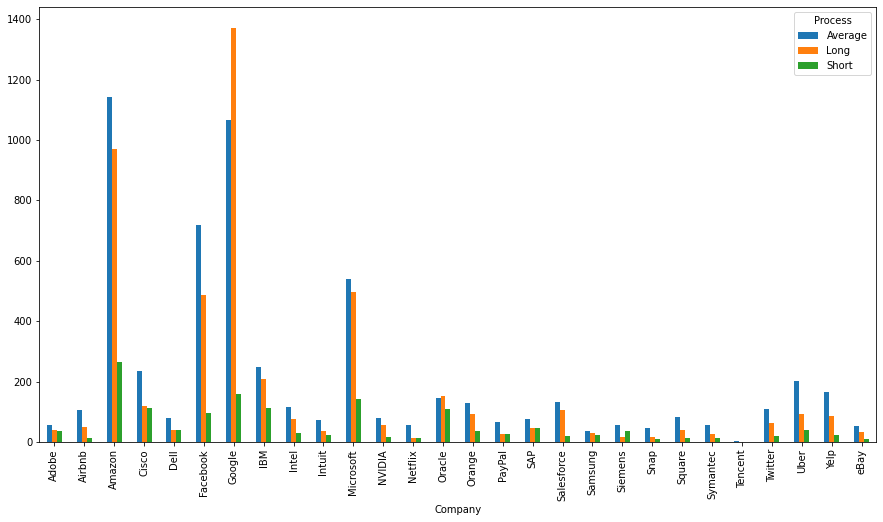

In [39]:
# Group the DataFrame by "Company" and "Process", count the number of elements,
# then unstack by "Process", then plot a bar chart
df.groupby(["Company", "Process"]).size().unstack(level=1).plot(kind="bar", figsize=(15, 8))

## 6. Common pitfalls
pandas is great for most day-to-day data analysis. It's instrumental to my job and I'm grateful that the entire pandas community is actively developing it. However, I think some of pandas design decisions are a bit questionable.

Some of the common pandas pitfalls:
### 6.1 NaNs
NaNs are stored as floats in pandas, so when an operation fails because of NaNs, it doesn't say that there's a NaN but because that operation doesn't exist for floats.

### 6.2 Changes not Inplace 
Most pandas operations aren't inplace by default, so if you make changes to your `DataFrame`, you need to assign the changes back to your DataFrame. You can make changes inplace by setting argument `inplace=True`.

In [40]:
# "Process" column is still in df
df.drop(columns=["Process"])
df.columns

Index(['Company', 'Title', 'Job', 'Level', 'Date', 'Upvotes', 'Offer',
       'Experience', 'Difficulty', 'Review', 'Process'],
      dtype='object')

In [41]:
# To make changes to df, set `inplace=True`
df.drop(columns=["Process"], inplace=True)
df.columns
# This is equivalent to
# df = df.drop(columns=["Process"])

Index(['Company', 'Title', 'Job', 'Level', 'Date', 'Upvotes', 'Offer',
       'Experience', 'Difficulty', 'Review'],
      dtype='object')

### 6.3 Performance issues with very large datasets

### 6.4 Reproducibility issues
Especially with dumping and loading `DataFrame` to/from files. There are two main causes:

- Problem with labels (see the section about labels above).
- [Weird rounding issues for floats](https://stackoverflow.com/questions/47368296/pandas-read-csv-file-with-float-values-results-in-weird-rounding-and-decimal-dig). 

### 6.5 Not GPU compatible
pandas can't take advantage of GPUs, so if your computations are on on GPUs and your feature engineering is on CPUs, it can become a time bottleneck to move data from CPUs to GPUs. If you want something like pandas but works on GPUs, check out dask and modin.